##Prepare Notebook

In [ ]:
import ee
import geemap
from osgeo import gdal, ogr

In [ ]:
!pip install geedim --quiet
!pip install rasterio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 57.3 MB/s eta 0:00:00


In [ ]:
#Authenticate one per session
ee.Authenticate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize the Earth Engine library
ee.Initialize(project='ee-nip')

##Load Shapefile

In [ ]:
import geopandas as gpd
import numpy as np

shapefile_path = '/content/guwahati.geojson'
gdf = gpd.read_file(shapefile_path)

# Check the geometry type
geom_type = gdf.geometry.geom_type.unique()
print("Geometry types in the shapefile:", geom_type)

# Calculations for Polygon geometries
if 'Polygon' in geom_type or 'MultiPolygon' in geom_type:
    # Reproject to a CRS that allows for meaningful area and length calculations (e.g., a UTM zone)
    gdf = gdf.to_crs('3857')  # Replace 'your_utm_crs' with an appropriate UTM CRS

    # Calculate area (in square units of the CRS, e.g., square meters)
    gdf['area'] = gdf.geometry.area

    # Calculate bounding box length and width (proxy for length and width of each polygon)
    gdf['bbox_length'] = gdf.geometry.bounds['maxy'] - gdf.geometry.bounds['miny']
    gdf['bbox_width'] = gdf.geometry.bounds['maxx'] - gdf.geometry.bounds['minx']

    print(gdf[['area', 'bbox_length', 'bbox_width']])

# Calculations for LineString geometries
elif 'LineString' in geom_type or 'MultiLineString' in geom_type:
    # Calculate the total length of each LineString (in the units of the CRS)
    gdf['length'] = gdf.geometry.length
    print(gdf[['length']])
else:
    print("The shapefile does not contain Polygon or LineString geometries.")


Geometry types in the shapefile: ['Polygon']
           area   bbox_length    bbox_width
0  2.452557e+08  16142.621605  15193.055628


###View Shapefile

In [ ]:
import geopandas as gpd
import folium

def plot_shapefile_on_map(shapefile_path):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Convert to EPSG:4326 if necessary
    if gdf.crs is not None and gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')

    # Calculate the center of the map
    center = gdf.unary_union.centroid.coords[0][::-1]

    # Create a folium map
    m = folium.Map(location=center, zoom_start=12)

    # Add the shapefile data to the map
    folium.GeoJson(
        gdf.to_json(),
        style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 1},
        name='Shapefile Layer'
    ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m

# Define the path to your shapefile
# shapefile_path = '/content/guwahati.geojson'
shapefile_path = '/content/EligibleShapefiles3x3kmV2/grid_0.geojson'

# Plot and display the map
m = plot_shapefile_on_map(shapefile_path)
m.save("shapefile_map.html")  # Save the map as an HTML file
m  # If using a Jupyter Notebook, this will display the map inline


In [ ]:
import geopandas as gpd
import os
import numpy as np
from shapely.geometry import box

def create_3km_grids(polygon, grid_size=11500):
    """Create 3km x 3km grids for a given polygon."""
    minx, miny, maxx, maxy = polygon.bounds
    grid_cells = []
    for x0 in np.arange(minx, maxx, grid_size):
        for y0 in np.arange(miny, maxy, grid_size):
            # Bounds
            x1 = x0 + grid_size
            y1 = y0 + grid_size
            grid_cells.append(box(x0, y0, x1, y1))
    return gpd.GeoDataFrame(geometry=grid_cells, crs='EPSG:3857')

def filter_eligible_grids(original_polygon, grids):
    """Filter grids that are completely within the original polygon and close to 9 km²."""
    eligible_grids = []
    for grid in grids.itertuples():
        if original_polygon.contains(grid.geometry) and grid.geometry.area >= 8.9e+6:  # 8.9e+6 sq meters ~ 9 sq km
            eligible_grids.append(grid.geometry)
    print(f"Number of eligible grids: {len(eligible_grids)}")
    return gpd.GeoDataFrame(geometry=eligible_grids, crs='EPSG:3857')

def save_grids(grids, output_folder):
    """Save each grid as a separate GeoJSON file, converted to EPSG:4326."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, grid in enumerate(grids.geometry):
        grid_gdf = gpd.GeoDataFrame(geometry=[grid], crs=grids.crs)
        # Convert to EPSG:4326 before saving
        grid_gdf = grid_gdf.to_crs('EPSG:4326')
        grid_gdf.to_file(os.path.join(output_folder, f"grid_{i}.geojson"), driver="GeoJSON")

def main(geojson_path, output_folder):
    gdf = gpd.read_file(geojson_path)
    gdf = gdf.to_crs('EPSG:3857')  # Convert CRS to EPSG:3857 for calculations
    print(f"Converted GeoDataFrame CRS: {gdf.crs}")
    original_polygon = gdf.unary_union
    print(f"Original Polygon Area: {original_polygon.area} in EPSG:3857")
    grids = create_3km_grids(original_polygon)
    eligible_grids = filter_eligible_grids(original_polygon, grids)
    save_grids(eligible_grids, output_folder)

# Define the input and output paths
geojson_path = '/content/Shapefile/guwahati.geojson'  # Replace with the path to your GeoJSON file
output_folder = "EligibleShapefiles3x3kmV2"

main(geojson_path, output_folder)


Converted GeoDataFrame CRS: EPSG:3857
Original Polygon Area: 245255748.03668502 in EPSG:3857
Number of eligible grids: 1


##Download the S1 and DW images for finetuning

#####Download 1 scene to check how it looks

In [ ]:
# Extract the base filename without extension
import os
base_filename = os.path.splitext(os.path.basename(shapefile_path))[0]
dw_output_path = f'{base_filename}_S1.tif'  # Modified filename with _S1.tif

In [ ]:
import geopandas as gpd
import ee
import geemap
import os
import numpy as np
import rasterio
from datetime import datetime, timedelta

# Define the check_image_completeness function
def check_image_completeness(image_path):
    with rasterio.open(image_path) as src:
        img_array = src.read(1)
        total_count = img_array.size

        nan_count = np.isnan(img_array).sum()
        nan_ratio = nan_count / total_count

        print(f"Ratio of NaN values: {nan_ratio}")

    return 0 < 0.1 #for testing

# Define the main download function
def download_image(start_date, end_date, feature, base_filename):
    collection = ee.ImageCollection('COPERNICUS/S1_GRD')
    polygonBounds = feature.geometry().bounds().getInfo()['coordinates']
    scale = 10  # Sentinel-1 native resolution

    try:
        filtered_collection = collection.filterBounds(feature) \
                                        .filterMetadata('instrumentMode', 'equals', 'IW') \
                                        .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH']) \
                                        .filterDate(ee.Date(start_date), ee.Date(end_date))

        selected_image = filtered_collection.first()
        if selected_image:
            dw_output_path = f'{base_filename}_{start_date}_S1.tif'
            geemap.download_ee_image(selected_image, filename=dw_output_path, region=polygonBounds, crs='EPSG:3857', scale=scale)
            return dw_output_path
        else:
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Your original code for setting up the GeoDataFrame
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs('EPSG:4326')
feature = ee.FeatureCollection(gdf.__geo_interface__)
base_filename = os.path.splitext(os.path.basename(shapefile_path))[0]

# Iterate through the date range
end_date = datetime(2023, 9, 27)
start_date = datetime(2021, 11, 22)

while end_date >= start_date:
    str_end_date = end_date.strftime('%Y-%m-%d')
    str_start_date = (end_date - timedelta(days=3)).strftime('%Y-%m-%d')

    dw_output_path = download_image(str_start_date, str_end_date, feature, base_filename)
    if dw_output_path and check_image_completeness(dw_output_path):
        print(f"Image from {str_start_date} to {str_end_date} meets the criteria.")
        break

    end_date -= timedelta(days=5)  # Move back in time


An error occurred: argument of type 'NoneType' is not iterable
An error occurred: argument of type 'NoneType' is not iterable


guwahati_2023-09-14_S1.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values: 0.0
Image from 2023-09-14 to 2023-09-17 meets the criteria.


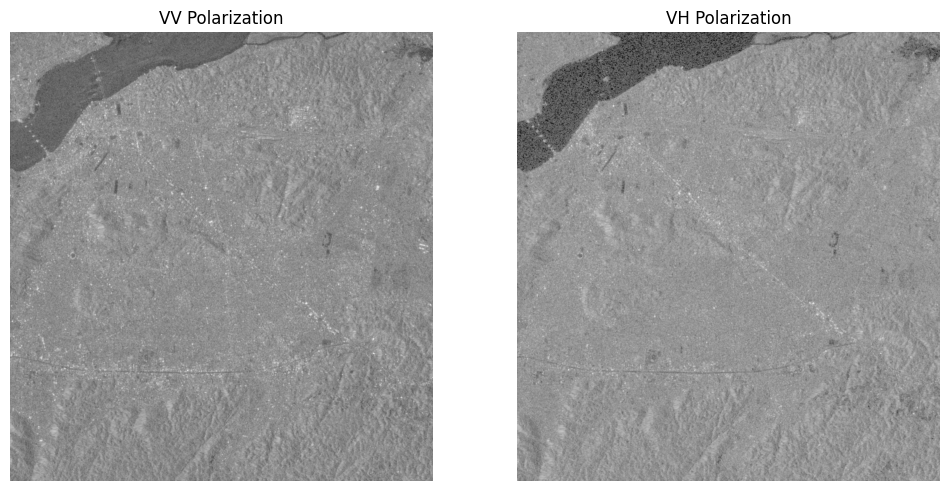

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the raster image
with rasterio.open(dw_output_path) as src:
    # Read the VV polarization band (usually the first band)
    vv = src.read(1)  # Adjust the band number if necessary

    # Read the VH polarization band (usually the second band)
    vh = src.read(2)  # Adjust the band number if necessary

    # Replace NaNs and infinities with zero
    vv_processed = np.nan_to_num(vv)
    vh_processed = np.nan_to_num(vh)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # VV polarization image
    ax[0].imshow(vv_processed, cmap='gray')
    ax[0].set_title("VV Polarization")
    ax[0].axis('off')

    # VH polarization image
    ax[1].imshow(vh_processed, cmap='gray')
    ax[1].set_title("VH Polarization")
    ax[1].axis('off')

    plt.show()



#####if you want to infer 1 image with the global model then provide this folder's name during inference

In [ ]:
if os.path.exists('InferOneImage'):
  pass
else:
  os.mkdir('InferOneImage')

os.system(f'mv {dw_output_path} InferOneImage/')

0

#####Download the pairs

In [ ]:
import gc
import os
import datetime
import logging
import time
import ee
import geemap
import geopandas as gpd
import rasterio
import numpy as np
import json  # For handling JSON files
import glob  # For listing files in a directory

def initialize_ee():
    ee.Initialize()

def create_output_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def geojson_to_ee_object(geojson_path):
    with open(geojson_path) as f:
        geojson = json.load(f)
    return ee.FeatureCollection(geojson)

def check_image_completeness(image_path, image_type):
    with rasterio.open(image_path) as src:
        img_array = src.read(1)
        total_count = img_array.size
        nan_count = np.isnan(img_array).sum()
        nan_ratio = nan_count / total_count
        print(f"Ratio of NaN values in {image_type}: {nan_ratio}")
        return nan_ratio < 0.2

def main(geojson_path, output_folder, start_date, end_date, shapefile_name):
    initialize_ee()
    create_output_folder(output_folder)

    aoi = geojson_to_ee_object(geojson_path)
    date_generated = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days, 3)]

    for date in date_generated:
        date_str = date.strftime('%Y-%m-%d')
        print(date_str)

        start = ee.Date(date_str)
        end = start.advance(3, 'day')

        dw_collection = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").filterDate(start, end).filterBounds(aoi)
        s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filterDate(start, end).filterBounds(aoi)

        if dw_collection.size().getInfo() > 0 and s1_collection.size().getInfo() > 0:
            dw_image = dw_collection.first().select(['water'])
            s1_image = s1_collection.first()

            scale = 10  # Explicitly setting the scale to 10 meters
            polygonBounds = aoi.geometry().bounds()

            dw_output_path = os.path.join(output_folder, f"DW{date_str}_{shapefile_name}.tif")
            s1_output_path = os.path.join(output_folder, f"S1{date_str}_{shapefile_name}.tif")

            geemap.download_ee_image(dw_image, filename=dw_output_path, region=polygonBounds, crs='EPSG:3857', scale=scale)

            if check_image_completeness(dw_output_path, "DW"):
                geemap.download_ee_image(s1_image, filename=s1_output_path, region=polygonBounds, crs='EPSG:3857', scale=scale)
                if check_image_completeness(s1_output_path, "S1"):
                    continue
                else:
                    os.remove(s1_output_path)
                    continue
            else:
                os.remove(dw_output_path)
                continue

# Initialize logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Define directories and dates
output_folder = "S1DWPairs_FineTune"  # Folder to store the output images
start_date = datetime.datetime(2023, 6, 1)
end_date = datetime.datetime(2023, 12, 31)

# Directory containing the shapefiles
shapefile_dir = "/content/Shapefile"  # Update this path to your shapefile directory

# Iterate over all shapefiles in the directory
for shapefile_path in glob.glob(os.path.join(shapefile_dir, '*.geojson')):
    shapefile_name = os.path.splitext(os.path.basename(shapefile_path))[0]
    main(shapefile_path, output_folder, start_date, end_date, shapefile_name)


2023-06-01
2023-06-04


DW2023-06-04_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.13541482200686772


S12023-06-04_guwahati.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.9995554497102485
2023-06-07
2023-06-10
2023-06-13
2023-06-16
2023-06-19
2023-06-22
2023-06-25


DW2023-06-25_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.5448444175760203
2023-06-28
2023-07-01
2023-07-04


DW2023-07-04_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.7513824007751133
2023-07-07
2023-07-10
2023-07-13
2023-07-16
2023-07-19
2023-07-22
2023-07-25
2023-07-28
2023-07-31
2023-08-03
2023-08-06
2023-08-09
2023-08-12
2023-08-15
2023-08-18
2023-08-21
2023-08-24
2023-08-27


DW2023-08-27_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.8872873679732456
2023-08-30
2023-09-02


DW2023-09-02_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.9990685612976634
2023-09-05
2023-09-08
2023-09-11
2023-09-14
2023-09-17


DW2023-09-17_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.36861971613102834
2023-09-20
2023-09-23
2023-09-26


DW2023-09-26_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.8314849078840505
2023-09-29
2023-10-02
2023-10-05
2023-10-08
2023-10-11


DW2023-10-11_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.5484793896796755
2023-10-14
2023-10-17
2023-10-20
2023-10-23
2023-10-26
2023-10-29
2023-11-01


DW2023-11-01_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.0


S12023-11-01_guwahati.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
2023-11-04
2023-11-07
2023-11-10
2023-11-13
2023-11-16
2023-11-19
2023-11-22
2023-11-25
2023-11-28
2023-12-01
2023-12-04
2023-12-07
2023-12-10


DW2023-12-10_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.21400659090585264
2023-12-13
2023-12-16
2023-12-19
2023-12-22


DW2023-12-22_guwahati.tif: |          | 0.00/19.7M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in DW: 0.0


S12023-12-22_guwahati.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
2023-12-25
2023-12-28


In [ ]:
#Processing Step: Set up the training data
import os
import shutil

# Define source and target directories
source_dir = '/content/S1DWPairs_FineTune'
target_dir_base = '/content/S1DWPairs_FineTune_TrainingDataset'
s1_target_dir = os.path.join(target_dir_base, 'S1')
dw_target_dir = os.path.join(target_dir_base, 'DW')

# Function to create directory if it does not exist
def create_dir_if_not_exists(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Create target directories
create_dir_if_not_exists(s1_target_dir)
create_dir_if_not_exists(dw_target_dir)

# Function to move file to target directory
def move_file_to_target(file, target_dir):
    shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

# Processing files in the source directory
for file in os.listdir(source_dir):
    if file.endswith('.tif') and file.startswith('S1'):
        date = file.split('-')[1]  # Extracting the date from the filename
        dw_file = 'DW' + file[2:]  # Constructing the corresponding DW filename

        if dw_file in os.listdir(source_dir):  # Check if the DW pair exists
            move_file_to_target(file, s1_target_dir)  # Move S1 file
            move_file_to_target(dw_file, dw_target_dir)  # Move DW file


In [ ]:
#Convert the labels to binary
import os
import rasterio

def convert_to_binary(input_folder, output_folder):
    # Check if output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the GeoTIFF file
            with rasterio.open(input_path) as src:
                # Read the data
                data = src.read(1)

                # Apply binary conversion
                binary_data = (data > 0.5).astype('uint8')

                # Save the modified data to a new file
                with rasterio.open(
                    output_path,
                    'w',
                    driver='GTiff',
                    height=binary_data.shape[0],
                    width=binary_data.shape[1],
                    count=1,
                    dtype=binary_data.dtype,
                    crs=src.crs,
                    transform=src.transform
                ) as dst:
                    dst.write(binary_data, 1)

# Define the input and output folder paths
input_folder = '/content/S1DWPairs_FineTune_TrainingDataset/DW' # Replace with your input folder path
output_folder = '/content/S1DWPairs_FineTune_TrainingDataset/DWBinary' # Replace with your output folder path

# Run the conversion function
convert_to_binary(input_folder, output_folder)


####Preprocess Training Data - S1 and DW

In [ ]:
#clean S1 from nans
import os

# Specify the directory
input_folder = '/content/S1DWPairs_FineTune_TrainingDataset/S1'

# Iterate over the files
for filename in os.listdir(input_folder):
    # If the filename contains 'S1'
    if 'S1' in filename:
        # Replace 'S1' with 'DW' in the filename
        new_filename = filename.replace('S1', 'DW')
        # Get full paths
        old_file_path = os.path.join(input_folder, filename)
        new_file_path = os.path.join(input_folder, new_filename)
        # Rename the file
        os.rename(old_file_path, new_file_path)


In [ ]:
#clean DW from nans
import os
import numpy as np
import rasterio

input_folder = '/content/S1DWPairs_FineTune_TrainingDataset/DWBinary'

# Iterate over the files
for filename in os.listdir(input_folder):
    # Check the file extension
    _, extension = os.path.splitext(filename)
    if extension.lower() == '.tif':
        file_path = os.path.join(input_folder, filename)
        with rasterio.open(file_path, 'r+') as src:
            # Read each band
            for i in range(1, src.count + 1):
                band = src.read(i)
                # Replace NaNs with 0s
                band[np.isnan(band)] = 0
                # Write the modified band back to the file
                src.write(band, i)

In [ ]:
#pre-processing the training data S1
inputInference = '/content/S1DWPairs_FineTune_TrainingDataset/S1'
outputInference = '/content/S1DWPairs_FineTune_TrainingDataset/S1_256'

# Ensure the output folder exists
os.makedirs(outputInference, exist_ok=True)

In [ ]:
import rasterio
from rasterio.windows import Window
import os
import glob

def extract_and_save_patches(img_path, output_folder, patch_size=256):
    """
    Extracts 256x256 patches from a geotiff image and saves them in the specified folder.
    """
    with rasterio.open(img_path) as dataset:
        width, height = dataset.width, dataset.height
        profile = dataset.profile

        x_start_points = list(range(0, width - patch_size, patch_size)) + [width - patch_size]
        y_start_points = list(range(0, height - patch_size, patch_size)) + [height - patch_size]

        for x in x_start_points:
            for y in y_start_points:
                window = Window(x, y, patch_size, patch_size)
                data = dataset.read(window=window)

                profile.update({
                    'width': patch_size,
                    'height': patch_size,
                    'transform': rasterio.windows.transform(window, dataset.transform)
                })

                # Generate unique patch filename
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                patch_filename = f"{output_folder}/{base_name}_{x}_{y}.tif"
                with rasterio.open(patch_filename, 'w', **profile) as dst:
                    dst.write(data)

def process_folder(input_folder, output_folder_base, patch_size=256):
    """
    Process all geotiff images in a folder, extracting patches from each.
    """
    if not os.path.exists(output_folder_base):
        os.makedirs(output_folder_base)

    for img_path in glob.glob(os.path.join(input_folder, '*.tif')):
        extract_and_save_patches(img_path, output_folder_base, patch_size)
        print(f"Patches for {img_path} saved in '{output_folder_base}'.")

# Example usage
input_folder = inputInference
output_folder_base = outputInference
process_folder(input_folder, output_folder_base)


In [ ]:
#pre-processing the training data S1
inputInference = '/content/S1DWPairs_FineTune_TrainingDataset/DWBinary'
outputInference = '/content/S1DWPairs_FineTune_TrainingDataset/DW_256'

# Ensure the output folder exists
os.makedirs(outputInference, exist_ok=True)

In [ ]:
import rasterio
from rasterio.windows import Window
import os
import glob

def extract_and_save_patches(img_path, output_folder, patch_size=256):
    """
    Extracts 256x256 patches from a geotiff image and saves them in the specified folder.
    """
    with rasterio.open(img_path) as dataset:
        width, height = dataset.width, dataset.height
        profile = dataset.profile

        x_start_points = list(range(0, width - patch_size, patch_size)) + [width - patch_size]
        y_start_points = list(range(0, height - patch_size, patch_size)) + [height - patch_size]

        for x in x_start_points:
            for y in y_start_points:
                window = Window(x, y, patch_size, patch_size)
                data = dataset.read(window=window)

                profile.update({
                    'width': patch_size,
                    'height': patch_size,
                    'transform': rasterio.windows.transform(window, dataset.transform)
                })

                # Generate unique patch filename
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                patch_filename = f"{output_folder}/{base_name}_{x}_{y}.tif"
                with rasterio.open(patch_filename, 'w', **profile) as dst:
                    dst.write(data)

def process_folder(input_folder, output_folder_base, patch_size=256):
    """
    Process all geotiff images in a folder, extracting patches from each.
    """
    if not os.path.exists(output_folder_base):
        os.makedirs(output_folder_base)

    for img_path in glob.glob(os.path.join(input_folder, '*.tif')):
        extract_and_save_patches(img_path, output_folder_base, patch_size)
        print(f"Patches for {img_path} saved in '{output_folder_base}'.")

# Example usage
input_folder = inputInference
output_folder_base = outputInference
process_folder(input_folder, output_folder_base)


##Setup the Deep Learning Model

###Loading Libraries

In [ ]:
#Need to install fastai, PIL, typing, and rasterio

from fastai.imports import *
from fastai.torch_imports import *
from packaging.version import parse
from fastai.vision.all import *
from fastcore.transform import Pipeline

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, IntToFloatTensor, Normalize, RandomSplitter, ToTensor, parent_label

from fastai.torch_core import to_device

from fastai.vision.augment import aug_transforms, Resize, RandomResizedCrop, FlipItem
from fastai.vision.data import ImageBlock, PILImage, get_image_files, imagenet_stats

from PIL import Image
from typing import Tuple

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from collections import defaultdict
import numpy as np
import subprocess

###Load Training Dataset


In [ ]:
#This is the subset of the main training dataset (provided)
# urlTD = 'https://drive.google.com/uc?id=1GvcP1fr0ZNiPOqgL8aNm7xfXmCu0eTJK'
# !gdown {urlTD}

!unzip -q /content/drive/MyDrive/surfaceWaterPipelineData/S1DWdatasetTiny.zip

In [ ]:
input_folder = '/content/S1DWdatasetTiny/images'
output_folder = '/content/S1DWdatasetTiny/images'

In [ ]:
import os

# Specify the directory
input_folder = output_folder

# Iterate over the files
for filename in os.listdir(input_folder):
    # If the filename contains 'S1'
    if 'S1' in filename:
        # Replace 'S1' with 'DW' in the filename
        new_filename = filename.replace('S1', 'DW')
        # Get full paths
        old_file_path = os.path.join(input_folder, filename)
        new_file_path = os.path.join(input_folder, new_filename)
        # Rename the file
        os.rename(old_file_path, new_file_path)


In [ ]:
import os
import numpy as np
import rasterio

# Iterate over the files
for filename in os.listdir(input_folder):
    # Check the file extension
    _, extension = os.path.splitext(filename)
    if extension.lower() == '.tif':
        file_path = os.path.join(input_folder, filename)
        with rasterio.open(file_path, 'r+') as src:
            # Read each band
            for i in range(1, src.count + 1):
                band = src.read(i)
                # Replace NaNs with 0s
                band[np.isnan(band)] = 0
                # Write the modified band back to the file
                src.write(band, i)

###Preparing Deep Learning Model


In [ ]:
#Classes for loading multi-channel bands

def open_npy(fn, chans=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    return im

def open_geotiff(fn, chans=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    return im

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[1], ctx=None, vmin=None, vmax=None, **kwargs):
        "These need refactoring"
        if len(channels) == 3:
            return show_composite(self, channels=channels, ctx=ctx, vmin=vmin, vmax=vmax,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1:
            return show_single_channel(self, channel=channels[0], ctx=ctx,
                                       **{**self._show_args, **kwargs})

    @classmethod
    def create(cls, fn, chans=None,  **kwargs) ->None:
        if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans))
        elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans))

    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'

MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create)

def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]
    if scale: im = norm(im, vmin, vmax)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None,
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], vmin=tempim[channel].min(), vmax=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax


def norm(vals, vmin=None, vmax=None):
    """
    For visualization purposes normalize image with `(vals-vmin)/(vmax-vmin),
    with vals either specified or within 0.01 and 0.99 quantiles of all values
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01))
    vmax = ifnone(vmax, np.quantile(vals, 0.99))
    return (vals - vmin)/(vmax-vmin)

In [ ]:
#define all band datablock
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None):
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans))

def _using_attr(f, attr, x):
    return f(getattr(x,attr))

def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

In [ ]:
#define multichannel data loader

class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, extensions=['.tif'],
                    train='train', valid='valid', valid_pct=None, seed=None,
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, extensions=['.tif'],
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    def from_name_func(cls, path, fnames, label_func,
                       chans=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, valid_pct=0.2, seed=None,
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas.
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    def from_csv(cls, path,  chans=None, csv_fname='labels.csv',
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels,chans=None, valid_pct=0.2,
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`. Specify dims to be either 2 (for 2d images) or 3 (for volumetric images)
        and optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(dims=dims, chans=chans), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)

MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [ ]:
#define method to get mask from the labels
def get_mask_from_tif(fn):
    return open_geotiff(fn, chans=[0])[0]

In [ ]:
#define segmentation dataloaders incl. images and masks

class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_funcs(cls, path, fnames, label_func, chans=None,
                         extensions=['.tif'], valid_pct=None, seed=None,
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans),
                                   MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
#segmentation classes
codes = ['other', 'water']; codes

['other', 'water']

In [ ]:
#Add Data Augmentations
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize()]

In [ ]:
#Define loss function for the deep learning model
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
cl = CombinedLoss()

###Setup the Global Model

In [ ]:
#setting up data loader, check the filepaths
dataLoaderS1Global = TifSegmentationDataLoaders.from_label_funcs(path='/content/S1DWdatasetTiny/images',
                                                   bs = 4,
                                                   codes=codes,
                                                   fnames = get_files('/content/S1DWdatasetTiny/images', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/S1DWdatasetTiny/labels/{o.stem}{o.suffix}'),
                                                   valid_pct=0.2,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

In [ ]:
#setup the deep learning model
modelS1Global =  unet_learner(dataLoaderS1Global, resnet34, metrics = [JaccardCoeff(), Dice()], loss_func=CombinedLoss(), opt_func=ranger, act_cls=Mish)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 78.9MB/s]


In [ ]:
#load the trained S1 global model (provided)
modelS1Global.load('/content/drive/MyDrive/surfaceWaterPipelineData/surfaceWaterTD2_V2')

##FineTune the global model (if required)

In [ ]:
#setting up data loader, check the filepaths
dataLoaderS1Local = TifSegmentationDataLoaders.from_label_funcs(path='/content/S1DWPairs_FineTune_TrainingDataset/S1_256',
                                                   bs = 8,
                                                   codes=codes,
                                                   fnames = get_files('/content/S1DWPairs_FineTune_TrainingDataset/S1_256', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/S1DWPairs_FineTune_TrainingDataset/DW_256/{o.stem}{o.suffix}'),
                                                   valid_pct=0.1,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

In [ ]:
#setup the deep learning model
modelS1Local =  unet_learner(dataLoaderS1Local, resnet34, metrics = [JaccardCoeff(), Dice()], loss_func=CombinedLoss(), opt_func=ranger, act_cls=Mish)

In [ ]:
#load the trained S1 global model (provided)
modelS1Local.load('/content/drive/MyDrive/surfaceWaterPipelineData/surfaceWaterTD2_V2')

SuggestedLRs(valley=0.0010000000474974513)

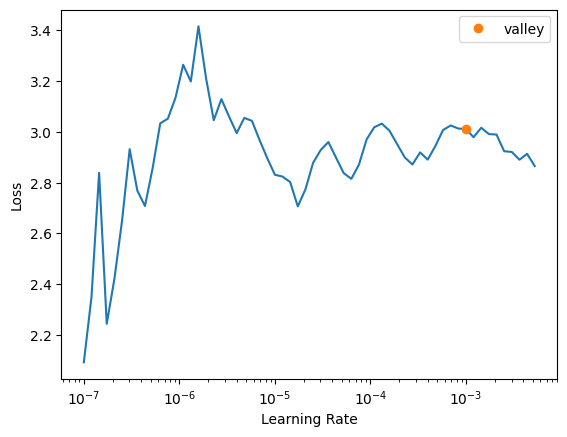

In [ ]:
#find lr
modelS1Local.lr_find()

In [ ]:
lr = 0.001

In [ ]:
modelS1Local.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,3.588345,2.122014,0.000000,0.000000,00:03
1,3.382982,2.988656,0.000000,0.000000,00:03
2,2.956954,2.890841,0.020537,0.040248,00:03
3,2.659244,2.873969,0.021246,0.041609,00:02
4,2.509161,2.823458,0.041237,0.079208,00:02
5,2.539667,2.960877,0.006250,0.012422,00:03
6,2.413158,2.990746,0.000000,0.000000,00:03
7,2.384655,2.953114,0.000000,0.000000,00:03
8,2.289802,2.965484,0.000000,0.000000,00:03
9,2.190918,2.971654,0.000000,0.000000,00:03


In [ ]:
lr = 0.001

In [ ]:
modelS1Local.fit_flat_cos(30, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,1.755187,2.991384,0.000000,0.000000,00:03
1,1.923141,2.975326,0.000000,0.000000,00:03
2,1.881118,2.993766,0.000000,0.000000,00:03
3,1.864340,2.924504,0.000000,0.000000,00:03
4,1.889056,2.964436,0.000000,0.000000,00:03
5,1.923145,2.999793,0.000000,0.000000,00:03
6,1.907191,3.012374,0.000000,0.000000,00:03
7,1.868722,3.003900,0.000000,0.000000,00:03


KeyboardInterrupt: 

##Get all the S1 images for this location


In [ ]:
import gc
import os
import datetime
import logging
import time
import zipfile  # For handling zip files
from zipfile import BadZipFile  # Specifically for BadZipFile exception
import ee  # Google Earth Engine
import geemap  # For Earth Engine operations in Python
import geopandas as gpd  # For handling geospatial data
import rasterio  # For raster operations
import numpy as np  # For numerical operations
import glob  # For file path operations
import json  # For handling JSON files

def initialize_ee():
    ee.Initialize()

def create_output_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def geojson_to_ee_object(geojson_path):
    with open(geojson_path) as f:
        geojson = json.load(f)
    return ee.FeatureCollection(geojson)

def check_image_completeness(image_path, image_type):
    with rasterio.open(image_path) as src:
        img_array = src.read(1)
        total_count = img_array.size
        nan_count = np.isnan(img_array).sum()
        nan_ratio = nan_count / total_count
        print(f"Ratio of NaN values in {image_type}: {nan_ratio}")
        return nan_ratio < 0.5

def main(geojson_path, output_folder, start_date, end_date):
    initialize_ee()
    create_output_folder(output_folder)

    aoi = geojson_to_ee_object(geojson_path)
    date_generated = [start_date + datetime.timedelta(days=x) for x in range((end_date-start_date).days)]

    for date in date_generated:
        date_str = date.strftime('%Y-%m-%d')
        print(date_str)

        start = ee.Date(date_str)
        end = start.advance(1, 'day')

        s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filterDate(start, end).filterBounds(aoi)

        if s1_collection.size().getInfo() > 0:
            s1_image = s1_collection.first()
            date_of_acquisitionS1 = ee.Date(s1_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
            scale = s1_image.select('VV').projection().nominalScale().getInfo()
            polygonBounds = aoi.geometry().bounds()

            s1_output_path = os.path.join(output_folder, f"S1_{date_of_acquisitionS1}.tif")

            try:
                geemap.download_ee_image(s1_image, filename=s1_output_path, region=polygonBounds, crs='EPSG:3857', scale=scale)
                if check_image_completeness(s1_output_path, "S1"):
                    print(f"Image {s1_output_path} passed completeness check.")
                else:
                    print(f"Image {s1_output_path} failed completeness check. Removing...")
                    os.remove(s1_output_path)
            except BadZipFile:
                logging.error(f"Bad zip file encountered for buffer related to {s1_output_path}")
                continue

# Initialize logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Define directories and dates
geojson_path = "/content/Shapefile/guwahati.geojson"
output_folder = "/content/InferAllS1Images"
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 1, 31)

# Execute the main function
main(geojson_path, output_folder, start_date, end_date)


2023-01-01


S1_2023-01-01.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.9998322758980058
Image /content/InferAllS1Images/S1_2023-01-01.tif failed completeness check. Removing...
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06


S1_2023-01-06.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
Image /content/InferAllS1Images/S1_2023-01-06.tif passed completeness check.
2023-01-07
2023-01-08


S1_2023-01-08.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
Image /content/InferAllS1Images/S1_2023-01-08.tif passed completeness check.
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13


S1_2023-01-13.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.999000168945394
Image /content/InferAllS1Images/S1_2023-01-13.tif failed completeness check. Removing...
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18


S1_2023-01-18.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
Image /content/InferAllS1Images/S1_2023-01-18.tif passed completeness check.
2023-01-19
2023-01-20


S1_2023-01-20.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
Image /content/InferAllS1Images/S1_2023-01-20.tif passed completeness check.
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25


S1_2023-01-25.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.9999963361239855
Image /content/InferAllS1Images/S1_2023-01-25.tif failed completeness check. Removing...
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30


S1_2023-01-30.tif: |          | 0.00/59.0M (raw) [  0.0%] in 00:00 (eta:     ?)

Ratio of NaN values in S1: 0.0
Image /content/InferAllS1Images/S1_2023-01-30.tif passed completeness check.


##Run inference

In [ ]:
#Load the S1 Scenes from Drive (provided)
# !unzip -q /content/drive/MyDrive/Workspace/FZ/inference/reachTests_74270100051_S1.zip

In [ ]:
#pre-processing the data after it has downloaded for inference
inputInference = '/content/InferAllS1Images'
outputInference = '/content/reachInference_S1_256'

# Ensure the output folder exists
os.makedirs(outputInference, exist_ok=True)

In [ ]:
import rasterio
from rasterio.windows import Window
import os
import glob

def extract_and_save_patches(img_path, output_folder, patch_size=256):
    """
    Extracts 256x256 patches from a geotiff image and saves them in the specified folder.
    """
    with rasterio.open(img_path) as dataset:
        width, height = dataset.width, dataset.height
        profile = dataset.profile

        x_start_points = list(range(0, width - patch_size, patch_size)) + [width - patch_size]
        y_start_points = list(range(0, height - patch_size, patch_size)) + [height - patch_size]

        for x in x_start_points:
            for y in y_start_points:
                window = Window(x, y, patch_size, patch_size)
                data = dataset.read(window=window)

                profile.update({
                    'width': patch_size,
                    'height': patch_size,
                    'transform': rasterio.windows.transform(window, dataset.transform)
                })

                # Generate unique patch filename
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                patch_filename = f"{output_folder}/{base_name}_{x}_{y}.tif"
                with rasterio.open(patch_filename, 'w', **profile) as dst:
                    dst.write(data)

def process_folder(input_folder, output_folder_base, patch_size=256):
    """
    Process all geotiff images in a folder, extracting patches from each.
    """
    if not os.path.exists(output_folder_base):
        os.makedirs(output_folder_base)

    for img_path in glob.glob(os.path.join(input_folder, '*.tif')):
        extract_and_save_patches(img_path, output_folder_base, patch_size)
        print(f"Patches for {img_path} saved in '{output_folder_base}'.")

# Example usage
input_folder = inputInference
output_folder_base = outputInference
process_folder(input_folder, output_folder_base)


Patches for /content/InferAllS1Images/S1_2023-01-08.tif saved in '/content/reachInference_S1_256'.
Patches for /content/InferAllS1Images/S1_2023-01-30.tif saved in '/content/reachInference_S1_256'.
Patches for /content/InferAllS1Images/S1_2023-01-20.tif saved in '/content/reachInference_S1_256'.
Patches for /content/InferAllS1Images/S1_2023-01-06.tif saved in '/content/reachInference_S1_256'.
Patches for /content/InferAllS1Images/S1_2023-01-18.tif saved in '/content/reachInference_S1_256'.


In [ ]:
#making sure there are no NaNs

input_folder = output_folder_base

# Iterate over the files
for filename in os.listdir(input_folder):
    # Check the file extension
    _, extension = os.path.splitext(filename)
    if extension.lower() == '.tif':
        file_path = os.path.join(input_folder, filename)
        with rio.open(file_path, 'r+') as src:
            # Read each band
            for i in range(1, src.count + 1):
                band = src.read(i)
                # Replace NaNs with 0s
                band[np.isnan(band)] = 0
                # Write the modified band back to the file
                src.write(band, i)


In [ ]:
#Set the dataset for inference
inferSet = [fn for fn in sorted((Path(output_folder_base)).glob('**/*')) if fn.is_file()]

In [ ]:
#Set the dataset for testing
test_dl = modelS1Local.dls.test_dl(inferSet)
# test_dl = modelS1Global.dls.test_dl(inferSet)

In [ ]:
#Get the predictions
preds = modelS1Local.get_preds(dl=test_dl)
# preds = modelS1Global.get_preds(dl=test_dl)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,1.755187,2.991384,0.000000,0.000000,00:03
1,1.923141,2.975326,0.000000,0.000000,00:03
2,1.881118,2.993766,0.000000,0.000000,00:03
3,1.864340,2.924504,0.000000,0.000000,00:03
4,1.889056,2.964436,0.000000,0.000000,00:03
5,1.923145,2.999793,0.000000,0.000000,00:03
6,1.907191,3.012374,0.000000,0.000000,00:03
7,1.868722,3.003900,0.000000,0.000000,00:03


In [ ]:
import os
from PIL import Image
import numpy as np

# Create a folder named 'output_images' if it doesn't exist
output_folder = 'predictedImages'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Your loop for saving images
for i, pred in enumerate(preds[0]):
    pred_arg = pred.argmax(dim=0).numpy().astype(np.uint8)
    im = Image.fromarray(pred_arg)

    # Extract the image name from its full path
    image_name = str(inferSet[i].name).split('/')[-1]

    # Combine the folder name with the image name
    save_path = os.path.join(output_folder, image_name)

    # Save the image in the specified folder
    im.save(save_path)

print(f"All images have been saved in the '{output_folder}' folder.")

All images have been saved in the 'predictedImages' folder.


In [ ]:
input_folder = 'predictedImages'
reference_folder = 'reachInference_S1_256'
output_folder = 'waterMapPredictions'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over all files in the input directory
for filename in os.listdir(input_folder):
    # Only process .tif files
    _, extension = os.path.splitext(filename)
    if extension.lower() != '.tif':
        continue

    input_filepath = os.path.join(input_folder, filename)
    reference_filepath = os.path.join(reference_folder, filename)

    # Read the reference image
    with rio.open(reference_filepath) as ref_src:
        ref_crs = ref_src.crs
        ref_transform = ref_src.transform

    # Read the original image
    with rio.open(input_filepath) as src:
        array = src.read()
        profile = src.profile

    # Update the profile with the reference CRS and transform
    profile.update({
        'crs': ref_crs,
        'transform': ref_transform,
    })

    # Write the image data back with the updated profile
    output_filepath = os.path.join(output_folder, filename)
    with rio.open(output_filepath, 'w', **profile) as dst:
        dst.write(array)


In [ ]:

# Step 1: Scan folder and organize files into groups
input_folder = r"/content/waterMapPredictions"
output_folder = r"/content/waterMapPredictions_mosaic"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

files = os.listdir(input_folder)
file_groups = defaultdict(list)

for file in files:
    if file.endswith('.tif'):
        prefix = "_".join(file.split("_")[:-2])  # Adjust depending on your specific naming pattern
        file_groups[prefix].append(os.path.join(input_folder, file))

# Step 2 and 3: Read files and mosaic them
for prefix, file_group in file_groups.items():
    src_files_to_mosaic = [rio.open(fp) for fp in file_group]

    # Merge function returns a single mosaic array and the transformation info
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Copy the metadata
    out_meta = src_files_to_mosaic[0].meta.copy()

    # Update the metadata
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans})

    # Step 4: Write the mosaic raster to disk
    with rio.open(os.path.join(output_folder, f"{prefix}.tif"), "w", **out_meta) as dest:
        dest.write(mosaic)


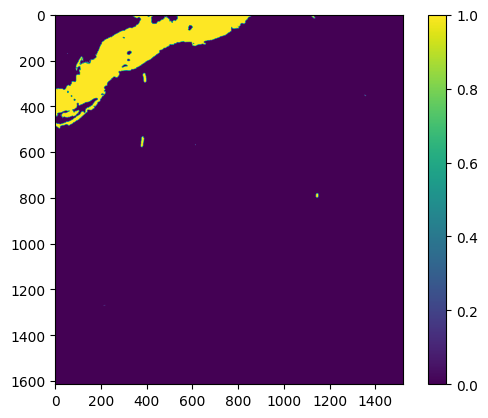

In [ ]:
# prompt: display a geotiff image

import rasterio
with rasterio.open('/content/waterMapPredictions_mosaic/S1_2023-01-20.tif') as src:
    plt.imshow(src.read(1))
    plt.colorbar()
    plt.show()


In [ ]:
# zip the mosaicked folder to download
!zip -r /content/waterMapPredictions_mosaic.zip waterMapPredictions_mosaic

  adding: waterMapPredictions_mosaic/ (stored 0%)
  adding: waterMapPredictions_mosaic/S1_2023-01-08.tif (deflated 100%)
  adding: waterMapPredictions_mosaic/S1_2023-01-30.tif (deflated 100%)
  adding: waterMapPredictions_mosaic/S1_2023-01-20.tif (deflated 100%)
  adding: waterMapPredictions_mosaic/S1_2023-01-06.tif (deflated 100%)
  adding: waterMapPredictions_mosaic/S1_2023-01-18.tif (deflated 100%)


In [ ]:
# zip the mosaicked folder to download
!zip -r InferAllS1Images.zip InferAllS1Images

  adding: InferAllS1Images/ (stored 0%)
  adding: InferAllS1Images/S1_2023-02-18.tif (deflated 7%)
  adding: InferAllS1Images/S1_2023-01-11.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-02-11.tif (deflated 8%)
  adding: InferAllS1Images/S1_2023-02-04.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-03-24.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-01-23.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-02-28.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-01-01.tif (deflated 7%)
  adding: InferAllS1Images/S1_2023-03-26.tif (deflated 7%)
  adding: InferAllS1Images/S1_2023-01-06.tif (deflated 8%)
  adding: InferAllS1Images/S1_2023-03-19.tif (deflated 8%)
  adding: InferAllS1Images/S1_2023-01-30.tif (deflated 8%)
  adding: InferAllS1Images/S1_2023-01-25.tif (deflated 7%)
  adding: InferAllS1Images/S1_2023-03-12.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-02-16.tif (deflated 5%)
  adding: InferAllS1Images/S1_2023-02-06.tif (deflated 7%)
  adding: InferA

##Delete Created Folders before starting again

In [ ]:
# !rm -rf /content/reachInference_S1_256
!rm -rf /content/predictedImages
!rm -rf /content/waterMapPredictions
!rm -rf /content/waterMapPredictions_mosaic

